In [64]:
# 1. import
import torch
from torch.utils.data import DataLoader
from torch import nn
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [65]:
# 2. download dataset
batch_size = 64

train_dataset = torchvision.datasets.MNIST(root="../assets/", train=True, download=True,
                                           transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_dataset = torchvision.datasets.MNIST(root="../assets/", train=False, download=True,
                                          transform=torchvision.transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=batch_size)

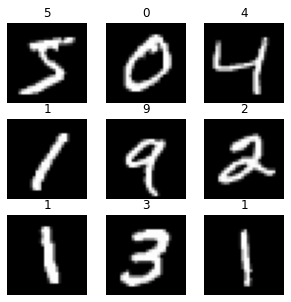

In [66]:
def plot():
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(5, 5))
    for i, (x, y) in enumerate(train_loader):
        if i == 0:
            for j in range(9):
                idx, idy = int(j / 3), j % 3
                axs[idx][idy].imshow(x[j].reshape((28, 28)), cmap="gray")
                axs[idx][idy].axis('off')
                axs[idx][idy].set_title(y[j].item())
        else:
            break
plot()

In [67]:
# loss record
sgd_epoch_loss=[]
momentum_epoch_loss=[]
adam_epoch_loss=[]

In [88]:
class MnistClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            # (1,28,28) => (16,28,28) => (16,14,14)
            nn.Conv2d(1, 16, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            # (16,14,14) => (32,14,14) => (32,7,7)
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            # (32,7,7) => (64,7,7) => (64,3,3)
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.linear = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # flatten (batch_size,32*7*7)
        x = self.linear(x)
        return x
# display model
model = MnistClassificationModel()
print(model)


MnistClassificationModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=576, out_features=128, bias=True)
    (1): ReLU()


In [89]:
# optimizer & cost function & params
epochs = 30
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters())
cost = nn.CrossEntropyLoss()

In [90]:
# device
use_cuda = torch.cuda.is_available()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(device)

cuda:0


In [91]:
# train
def train(_epoch_loss):
    model.train()
    for epoch in range(epochs):
        batch_loss = []
        for batch_id, (batch_x, batch_y) in enumerate(train_loader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            optimizer.zero_grad()  # set grad zero
            outputs = model(batch_x)  # forward
            loss = cost(outputs, batch_y)  # calc cost function
            loss.backward()  # backward
            optimizer.step()  # optimizer update

            if use_cuda:
                batch_loss.append(loss.data.cpu().numpy())
            else:
                batch_loss.append(loss.data.numpy())
            if batch_id % 100 == 0 and len(batch_x) == batch_size:
                print(f"\tepoch={epoch}/{epochs}({round(epoch / epochs * 100,2)}%), {batch_id * batch_size}/{len(train_loader.dataset)},loss={np.mean(batch_loss)}")
        _epoch_loss.append(np.mean(batch_loss))
        
train(adam_epoch_loss)

	epoch=0/30(0.0%), 0/60000,loss=2.3158459663391113
	epoch=0/30(0.0%), 6400/60000,loss=0.6670425534248352
	epoch=0/30(0.0%), 12800/60000,loss=0.41162410378456116
	epoch=0/30(0.0%), 19200/60000,loss=0.30870962142944336
	epoch=0/30(0.0%), 25600/60000,loss=0.25007542967796326
	epoch=0/30(0.0%), 32000/60000,loss=0.21540994942188263
	epoch=0/30(0.0%), 38400/60000,loss=0.19194020330905914
	epoch=0/30(0.0%), 44800/60000,loss=0.17526274919509888
	epoch=0/30(0.0%), 51200/60000,loss=0.16228275001049042
	epoch=0/30(0.0%), 57600/60000,loss=0.15120725333690643
	epoch=1/30(3.33%), 0/60000,loss=0.024724721908569336
	epoch=1/30(3.33%), 6400/60000,loss=0.0632348507642746
	epoch=1/30(3.33%), 12800/60000,loss=0.0656488835811615
	epoch=1/30(3.33%), 19200/60000,loss=0.05903574824333191
	epoch=1/30(3.33%), 25600/60000,loss=0.05358380451798439
	epoch=1/30(3.33%), 32000/60000,loss=0.05173930153250694
	epoch=1/30(3.33%), 38400/60000,loss=0.05125486105680466
	epoch=1/30(3.33%), 44800/60000,loss=0.050554491579532

In [92]:
# test
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for (test_x, test_y) in test_loader:
            test_x = test_x.to(device)
            test_y = test_y.to(device)

            output = model(test_x)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(test_y.data.view_as(pred)).sum()

    print(f"accuracy={correct / len(test_loader.dataset)}")


test()

accuracy=0.9914999604225159


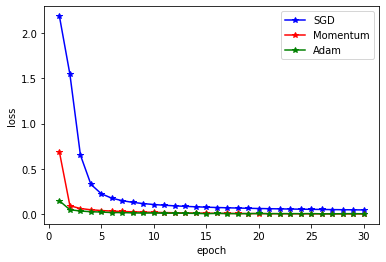

In [95]:
def visualize_loss():
    plt.plot(np.linspace(1,30,30),sgd_epoch_loss,'b*-')
    plt.plot(np.linspace(1,30,30),momentum_epoch_loss,'r*-')
    plt.plot(np.linspace(1,30,30),adam_epoch_loss,'g*-')
    plt.legend(['SGD','Momentum','Adam'])
    plt.xlabel('epoch')
    plt.ylabel('loss')

visualize_loss()

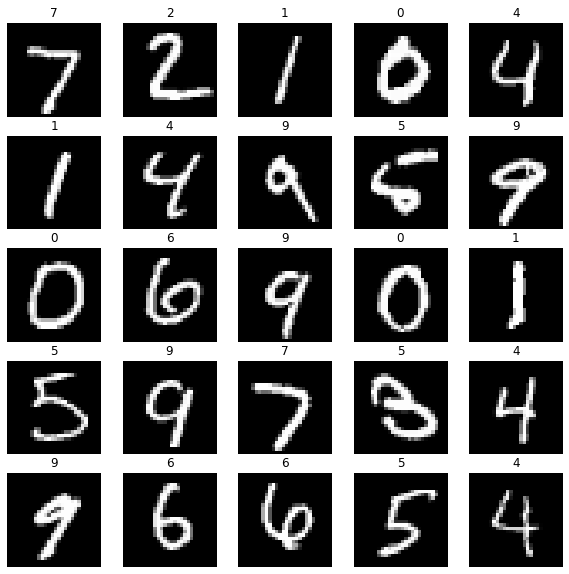

In [103]:
# visualize
def plot_test():
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

    for i, (test_x, test_y) in enumerate(test_loader):
        test_x = test_x.to(device)
        test_y = test_y.to(device)

        output = model(test_x)
        pred = output.data.max(1, keepdim=True)[1]
        if i == 0:
            for j in range(25):
                idx, idy = int(j / 5), j % 5
                axs[idx][idy].imshow(test_x[j].cpu().reshape((28, 28)), cmap="gray")
                axs[idx][idy].axis('off')
                axs[idx][idy].set_title(f"{pred[j].item()}")
        else:
            break
plot_test()

In [97]:
# export
def export():
    input_shape = torch.rand((1, 1, 28, 28))
    input_shape=input_shape.to(device)
    model.to(device)
    torch.onnx.export(model, input_shape, '../models/MNIST-cnn.onnx') # onnx model
    torch.save(model.state_dict(),'../models/MNIST-cnn.pkl') # pkl model
export()

In [98]:
# visualize model
import netron

def visualize_model():
    netron.start('../models/MNIST-cnn.onnx')

visualize_model()

Serving '../models/MNIST-cnn.onnx' at http://localhost:8080
